# Support Vector Machines

In this section of the assignment, you will get to implement Support Vector Machines which are among the best (and many believe are indeed the best) “off-the-shelf” supervised learning algorithm.

This section is further divided into 3 subsections.


*   In the first subsection, you will work on a synthetic dataset and visualize the boundary predicted by SVM. You will also vary the value of C-parameter and see how the decision boundary changes. **Please note that you cannot use inbuilt sklearn function for SVM in this sub-section**. You can only use a QCQP (Quadratically Constrained Quadratic Program) solver like CVXPY. 

  References which you may find helpful for this subsection: 
  
  1.   https://www.cvxpy.org/
  2.   https://www.cvxpy.org/examples/basic/quadratic_program.html

  Note that in this section you are expected to show how you derived the Quadratically Constrained form(which can be passed into the solver) from the basic principles of SVM algorithm
*  In the next subsection you will use be using the famous MNIST dataset to explore various kernels and report the results. **Please note you may use inbuilt sklearn SVM functions in this subsection**


In [112]:
!pip install numpy
!pip install matplotlib
!pip install cvxpy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from math import isclose

### Subsection 1

In [113]:
# Feel free to use this helper function to visualize 2D points X with labels +1 or -1
def plot_points(X, Y):
    reds = []
    blues = []
    for i in range(Y.shape[0]):
        if Y[i] == 1:
            reds.append(X[i])
        else:
            blues.append(X[i])
    reds = np.array(reds)
    blues = np.array(blues)
    plt.scatter(reds[:, 0], reds[:, 1], c = 'r')
    plt.scatter(blues[:, 0], blues[:, 1], c = 'b')

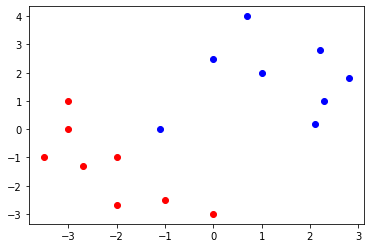

In [114]:
# Create Synthetic Data and visualize the points
X = np.array([[-3.5, -1], [-3, 0], [-3, 1], [-2.7, -1.3], [-2, -1], [-2, -2.7], 
              [-1, -2.5], [0, -3], [-1.1, 0], [0, 2.5], [1, 2], [0.7, 4], 
              [2.1, 0.2], [2.3, 1], [2.8, 1.8], [2.2, 2.8]])
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1])

plot_points(X, y)
plt.show()

In the next cell you are required to derive the Quadratic Constrained Quadratic form of SVM **without soft constraints** from the basic principles. Start with the idea that SVM tries to maximize the margin and then derive the form which you can feed to the solver.

Let vectors $x$ & $z$ be parallel vectors on the lines $w.x + b = -1$ & $w.x + b = 1$ respectively. 

Then, we have the following.
$$\vec{z} = \vec{x}+\vec{k}$$

Let the magnitude of $k$ be M. Then as $k$ and $w$ are in the same direction.
$$\vec{k} = M.\hat{w}$$

Since, $z$ lies on margin we obtain the following.
$$\vec{w}.\vec{z} + b = 1~~\text{or}~~\vec{w}.(\vec{k}+\vec{w})+ b = 1$$
$$\implies M = \frac{2}{\| w\| }$$

Thus, to maximize margin distance we have to minimize $\frac{1}{2}\| w\| ^{2}$. The conditions are as follows.

$$y_i(\vec{w}.\vec{x}_{i} + b) >= 1 \forall i \in N$$


Please print the values of w, b. 

**Note: You are also required to upload a page of the derivation. You may also type it in markdown here.**

**Note: You cannot use sklearn SVM functions here.**

In [115]:
# Write your code here
class SVM:
    def __init__(self, X, Y):
        self.X = X
        self.f = np.zeros((3, 3))
        self.var = cp.Variable(3)
        self.w = []
        self.b = 0
        self.Y = Y

    def update(self, X, Y, C):
        self.X = X
        self.f = np.zeros((3, 3))
        self.var = cp.Variable(3)
        self.w = []
        self.b = 0
        self.Y = Y
        self.C = C
        self.var2 = 0

    def solver(self):
        self.X = np.hstack((X, np.ones((X.shape[0],1))))
        self.f[0][0] = self.f[1][1] = 1
        cp.Problem(
            cp.Minimize(cp.quad_form(self.var, self.f) * 0.5),
            [(y * (x.T@self.var)) >= 1 for x, y in zip(self.X, self.Y)]
        ).solve()
        self.w = self.var.value[:2]
        self.b = self.var.value[2]

    def slack_solver(self):
        self.X = np.hstack((X, np.ones((X.shape[0],1))))
        self.f[0][0] = self.f[1][1] = 1
        self.var2 = cp.Variable(self.X.shape[0])
        cp.Problem(
            cp.Minimize(cp.quad_form(self.var, self.f) * 0.5 + self.C * cp.sum(self.var2)),
            [(y * (x.T@self.var)) >= (1 - self.var2[i])
             for x, y, i in zip(self.X, self.Y, range(self.X.shape[0]))]
             + [self.var2[i] >= 0 for  i in range(self.X.shape[0])]
        ).solve()
        self.w = self.var.value[:2]
        self.b = self.var.value[2]

In [116]:
model = SVM(X, y)
model.solver()
print("w: ", model.w)
print("b: ", model.b)

w:  [-1.73913043 -1.30434783]
b:  -2.91304347826087


In the next cell you are required to visualize the boundary predicted by the solver. You may want to revise up on how to plot the a line given w, b. Please plot w vector as well as the margin lines

You may want to create a function to plot the line of separation as you would require this frequently in the subsequent parts of the assignment.

In [117]:
# Write your code here
def plot_line():
    plot_points(X, y)
    axes = plt.gca()
    plt.plot(
        np.array(axes.get_xlim()), (
            -model.b/model.w[1]
            ) + (
                -model.w[0]/model.w[1]
            ) * np.array(axes.get_xlim())
    )

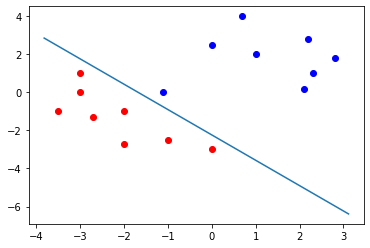

In [118]:
plot_line()
plt.show()

In the next cell please plot only the support vectors along with the boundary, w vector, and margins. 

**Note: You are not supposed to hard-code the points here.**

In [119]:
def plot_all():
    p = list(model.w)
    p.append(model.b)
    x = []
    y = []
    for (i, j) in zip(model.X, model.Y):
        if isclose(i.T@p, 1) or isclose(i.T@p, -1):
            x.append(i[:2])     # x values
            y.append(j)         # y values
    plot_points(np.array(x), np.array(y))
    model.b -= 1
    plot_line()
    model.b += 2
    plot_line()
    model.b -= 1
    plt.show()

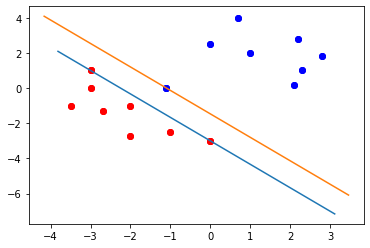

In [120]:
plot_all()

In the next cell add the following points:
* (-4, -10) with label 1
* (4, 4) with label -1

Is the decision boundary changed after adding the points? Explain your observations theoretically.

In [121]:
# Re-create the Synthetic Data by adding the points and visualize the points
X = np.append(X, [[-4, -10], [4, 4]], axis = 0)
y = np.append(y, [1, -1], axis = 0)

In [122]:
# Solve for the decision boundary using this modified dataset
model = SVM(X, y)
model.solver()
print("w: ", model.w)
print("b: ", model.b)

w:  [-1.73913043 -1.30434783]
b:  -2.9130434782608705


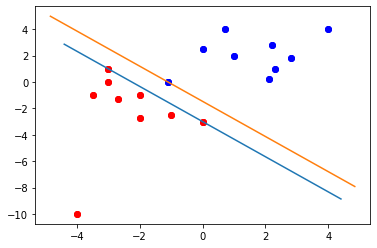

In [123]:
plot_all()

In the next cell you are required to modify your framing of optimisation problem to incorporate soft constraints also known as slack. Plot the decision boundary, w and margin lines for various values of C: $0.01$, $0.1$, $3$, $10$, $100$.

Explain your results theoretically. How does the boundary change with varying values of C? Why?

**Note: Use the modified X and y i.e after adding points in previous cell.**

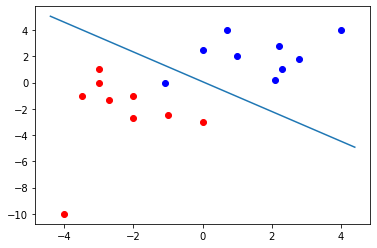

In [124]:
# Write your code here for C= 0.01
model = SVM(X, y)
model.update(X, y, 0.01)
model.slack_solver()
plot_line()
plt.show()

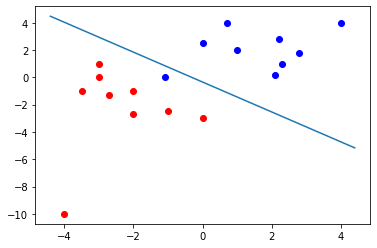

In [125]:
# Write your code here for C= 0.1
model.update(X, y, 0.1)
model.slack_solver()
plot_line()
plt.show()

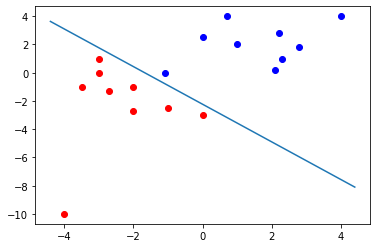

In [126]:
# Write your code here for C= 3
model.update(X, y, 3)
model.slack_solver()
plot_line()
plt.show()

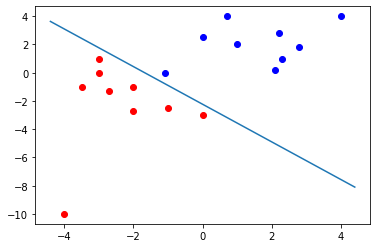

In [127]:
# Write your code here for C= 10
model.update(X, y, 10)
model.slack_solver()
plot_line()
plt.show()

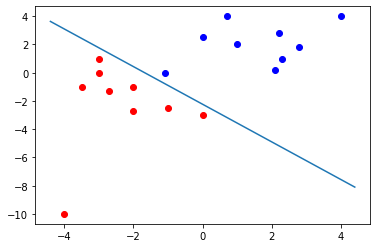

In [128]:
# Write your code here for C= 100
model.update(X, y, 100)
model.slack_solver()
plot_line()
plt.show()

Take the case of C = 100 and remove the support vectors. Does the boundary change after the deletion?
Explain why? Show your results by appropriate plots?

Yes the line will change because we were maximizing the distance between the two support vectors. We have a larger space now over which we are supposed to optimize for moaximizing distance.

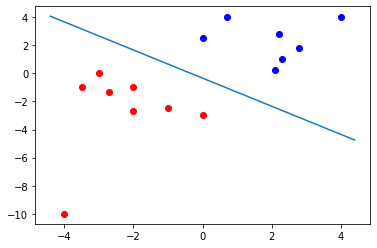

In [130]:
# Write your Code here
p = list(model.w)
p.append(model.b)
for (i, j, k) in zip(model.X, model.Y, range(model.X.shape[0])):
    if isclose(i.T@p, 1) or isclose(i.T@p, -1):
        X = np.delete(X, k, axis=0)
        y = np.delete(y, k, axis=0)
model.update(X, y, 100)
model.slack_solver()
plot_line()
plt.show()

### Subsection 2

In [131]:
!pip install python-mnist
!rm -rf samples
!mkdir samples
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P samples/
!gunzip samples/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P samples/
!gunzip samples/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P samples/
!gunzip samples/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P samples/
!gunzip samples/t10k-labels-idx1-ubyte.gz

--2021-12-05 17:03:41--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘samples/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.08s   

2021-12-05 17:03:41 (126 MB/s) - ‘samples/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2021-12-05 17:03:42--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘samples/train-labels-idx1-ubyte.gz’

train-label

In [132]:
# Import Relevant Packages
from sklearn.svm import SVC
import numpy as np
from mnist.loader import MNIST

In [133]:
mndata = MNIST('samples')

# Load training dataset
images, labels = mndata.load_training()
l = len(labels)
images_train = np.array(images)
labels_train = np.array(labels)

print(images_train.shape)
print(labels_train.shape)

(60000, 784)
(60000,)


In [134]:
# Load testing dataset
images, labels = mndata.load_testing()
l = len(labels)
images_test = np.array(images)
labels_test = np.array(labels)

print(images_test.shape)
print(labels_test.shape)

(10000, 784)
(10000,)


- Tweak different parameters like the C Parameter and gamma parameter of the Linear SVM and report the results.
- Experiment different kernels for classification and report the results.

Report accuracy score, F1-score, Confusion matrix and any other metrics you feel useful.

In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    images_test, 
    labels_test
)

In [136]:
from sklearn.metrics import accuracy_score
x = []
y = []
for C in range(1, 10):
    model = SVC(C = C, kernel = 'rbf')
    model.fit(X_train, y_train)
    y.append(accuracy_score(y_test, model.predict(X_test)))
    x.append(C)

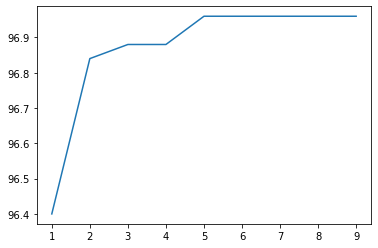

In [137]:
plt.plot(x, np.array(y) * 100)

In [138]:
from sklearn.metrics import accuracy_score
for kernel in ["linear", "poly", "rbf"]:
    model = SVC(C = C, kernel = kernel)
    model.fit(X_train, y_train)
    accuracy = 100 * accuracy_score(
        y_test, 
        model.predict(X_test)
    )
    print(f"Accuracy on {kernel} is {accuracy}")

Accuracy on linear is 92.64
Accuracy on poly is 95.44
Accuracy on rbf is 96.96000000000001
